In [109]:
import pandas as pd
import numpy as np
import pickle
from ast import literal_eval
import matplotlib.pyplot as plt
import copy
from collections import Counter

# Load Data

In [110]:
data1 = pd.read_csv("data/new.csv", encoding='utf-8')
data2 = pd.read_csv("data/old.csv", encoding='utf-8')
data3 = pd.read_csv("data/rush.csv", encoding='utf-8')

In [111]:
data = combined_df = pd.concat([data1, data2, data3], axis=0, ignore_index=True)

In [112]:
games = [pd.DataFrame(literal_eval(data['game details'].iloc[i])) for i in range(len(data))]
print(f"{len(games)} games in data file")

30396 games in data file


In [113]:
data.head()

,game type,no. players,blinds,players order,hero cards,players cards,game details,rake,jackpot
0,6-max,6,"[0.01, 0.02]","['9e0fad02', 'Hero', '82bc32eb', 'c52c668b', '...",[Tc Ac],"['', '[Tc Ac]', '', '', '', '']","{'player': ['9e0fad02', 'Hero', '82bc32eb', 'c...",0.00,0.0
1,6-max,6,"[0.01, 0.02]","['Hero', '82bc32eb', 'c52c668b', '49c58cd5', '...",[9c Ad],"['[9c Ad]', '', '', '', '', '']","{'player': ['Hero', '82bc32eb', 'c52c668b', '4...",0.02,0.0
2,6-max,6,"[0.01, 0.02]","['82bc32eb', 'c52c668b', '49c58cd5', '3831aebb...",[4s 8c],"['', '', '', '', '', '[4s 8c]']","{'player': ['82bc32eb', 'c52c668b', '49c58cd5'...",0.00,0.0
3,6-max,6,"[0.01, 0.02]","['c52c668b', '49c58cd5', '3831aebb', '9e0fad02...",[8s Qd],"['', '', '', '', '[8s Qd]', '']","{'player': ['c52c668b', '49c58cd5', '3831aebb'...",0.00,0.0
4,6-max,6,"[0.01, 0.02]","['49c58cd5', '3831aebb', '9e0fad02', 'Hero', '...",[4d 5s],"['', '', '', '[4d 5s]', '', '']","{'player': ['49c58cd5', '3831aebb', '9e0fad02'...",0.00,0.0


In [114]:
games[0].head()

,player,stack,action,actions_detail,round,position,tables_cards,round chips,pot
0,9e0fad02,2.96,sb,0.01,0,0,[],0.03,0.00
1,Hero,1.98,bb,0.02,0,1,[],0.03,0.01
2,82bc32eb,3.04,fold,0.00,0,2,[],0.03,0.03
3,c52c668b,2.55,fold,0.00,0,3,[],0.03,0.03
4,49c58cd5,5.23,fold,0.00,0,4,[],0.03,0.03


# Auxiliary Methods

In [115]:
def get_preflop_raiser(a_game: dict):
    return a_game[(a_game['round'] == 0) & (a_game['action'] == 'raise')]['player'].iloc[0]

def get_preflop_caller(a_game: dict):
    flop_players = set(a_game[(a_game['round'] == 1)]['player'])
    preflop_callers = a_game[(a_game['round'] == 0) & (a_game['action'] == 'call')]['player']
    for caller in preflop_callers:
        if caller in flop_players:
            return caller
    # return a_game[(a_game['round'] == 0) & (a_game['action'] == 'call')]['player'].iloc[0]

In [116]:
def plot_hist(values, use_range: tuple = (), bins = 0, title='', xlabel='', with_bar_nums=True):
    max_val, min_val = max(values), min(values)
    if len(use_range) == 0:
        use_range = (min_val, max_val)
    if bins == 0:
        bins = max_val - min_val + 1

    counts, bins, patches = plt.hist(values, bins=bins, alpha=0.7, color='blue', edgecolor='black', range=use_range)
    plt.title(title)
    plt.xlabel(xlabel)
    # Add counts above each bar
    if with_bar_nums is True:
        for count, x in zip(counts, bins):
            height = count
            plt.text(x + (bins[1] - bins[0]) / 2, height, int(height), ha='center', va='bottom')
    plt.show()

def plot_str_hist(str_list, title='', xlabel='', width_height=(12, 8), with_bar_nums=True):
    counts = Counter(str_list)
    plt.figure(figsize=(width_height[0], width_height[1]))
    plt.bar(counts.keys(), counts.values(), color='skyblue', edgecolor='black')
    if with_bar_nums is True:
        for category, count in counts.items():
            plt.text(category, count + 0.1, str(count), ha='center', va='bottom')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

# Filter

keep only relevant data:
- single raiser and single caller preflop (i.e. 2-way flop)
- checked to raiser and he cbet
- cbet in [0,1]
- 'Hero' is the raiser

In [117]:
# convert string to integer
for game in games:
    game['round'] = game['round'].replace('end', -1)
    game['round'] = game['round'].astype(int)

In [118]:
rel_games_inds = []
for i, game in enumerate(games):
    preflop_street = game[game['round'] == 0]
    flop_street = game[game['round'] == 1]

    # filter games with more or less than single preflop raiser
    if preflop_street['action'].isin(['bet', 'raise']).sum() != 1:
        continue

    # # filter games with more or less than single caller
    if len(set(flop_street['player'])) != 2:
        continue

    # keep only games where Hero is the raiser
    raiser = get_preflop_raiser(game)
    if raiser != 'Hero':
        continue

    # filter games without cbet (either got donk bet or skipped cbet) or with cbet/pot_size not in [0,1]
    for _, row in flop_street.iterrows():
        if row['player'] != raiser:
            if row['action'] != 'check':
                break
        else:
            if row['action'] == 'bet':
                if row['actions_detail'] / row['pot'] <= 1:
                    rel_games_inds.append(i)
                break

In [119]:
rel_data = data.iloc[rel_games_inds]
rel_games = [games[i] for i in rel_games_inds]

In [120]:
print(f"{len(rel_data)} relevant games remained")

939 relevant games remained


# Process data
split data into lists:
- i'th place in each list correspond to i'th game.
- treatment grouped into 10 categories (cbet to pot ratio, in [0.1, 0.2, ... , 0.9, 1])
- outcome grouped into 3 categories ('fold', 'call', 'raise')
- numeric continuous covariates scaled to [0,1] (rarely, might be bigger than 1)
- numeric categorical covariates remain unchanged

In [121]:
# general
raiser_caller_positions = []
hero_hands = []

# preflop
open_sizes = []
raisers_stack = []
callers_stack = []

# postflop
pot_sizes = []  # prior c-bet
flops_cards = []
treatments = []
outcomes = []
profits = []

In [122]:
for i1, game in enumerate(rel_games):

    raiser = get_preflop_raiser(game)
    caller = get_preflop_caller(game)
    hero_hands.append(rel_data['hero cards'].iloc[i1])

    # ----- preflop -----
    preflop_street = game[game['round'] == 0]

    open_size = preflop_street[preflop_street['action'] == 'raise']['actions_detail'].iloc[0]
    open_sizes.append(open_size)

    raiser_stack = preflop_street[preflop_street['player'] == raiser]['stack'].iloc[0]
    raisers_stack.append(raiser_stack)

    caller_stack = preflop_street[preflop_street['player'] == caller]['stack'].iloc[0]
    callers_stack.append(caller_stack)

    # ----- flop -----
    flop_street = game[game['round'] == 1]
    cbet_row = flop_street[flop_street['action'] == 'bet'].first_valid_index()
    respond_row = cbet_row + 1

    outcomes.append(game.iloc[respond_row]['action'])

    profit = game[(game['round'] == -1) & (game['player'] == raiser)]['actions_detail'].iloc[0]
    profits.append(profit)

    bet_value = game.iloc[cbet_row]['actions_detail']
    pot_value = game.iloc[cbet_row]['pot']
    pot_sizes.append(pot_value)
    treatments.append(bet_value / pot_value)

    raise_position = game.iloc[cbet_row]['position']
    caller_position = game.iloc[respond_row]['position']
    raiser_caller_positions.append((raise_position, caller_position))

    flops_cards.append(flop_street['tables_cards'].iloc[0])


adjust (by 100xbig_blind) and group values

In [123]:
bb = 0.02
bb100 = bb * 100

In [124]:
_treatments = [round(v, 1) for v in treatments]
_outcomes = copy.copy(outcomes)
_profits = [v/bb100 for v in profits]
_raiser_caller_positions = copy.copy(raiser_caller_positions)
_open_sizes = [v/bb100 for v in open_sizes]
_raisers_stack = [v/bb100 for v in raisers_stack]
_callers_stack = [v/bb100 for v in callers_stack]
_pot_sizes = [v/bb100 for v in pot_sizes]
_flops_cards = copy.copy(flops_cards)
_hero_hands = copy.copy(hero_hands)

In [125]:
split_data = {
    "_treatments": _treatments,
    "_outcomes": _outcomes,
    "_profits": _profits,
    "_raiser_caller_positions": _raiser_caller_positions,
    "_open_sizes": _open_sizes,
    "_raisers_stack": _raisers_stack,
    "_callers_stack": _callers_stack,
    "_pot_sizes": _pot_sizes,
    "_flops_cards": _flops_cards,
    "_hero_hands": _hero_hands
}
with open('data/raw_split_data.pkl', 'wb') as file:
    pickle.dump(split_data, file)

### Visualization

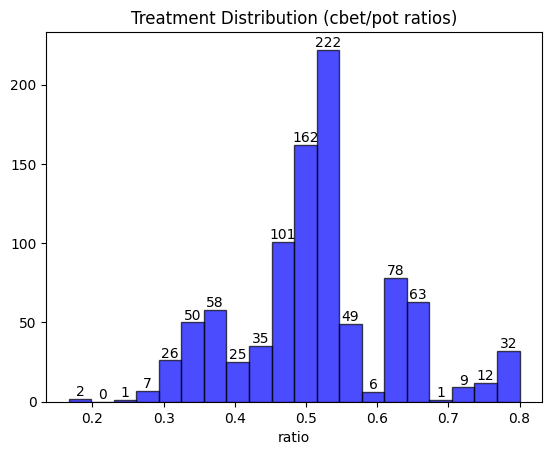

In [126]:
plot_hist(treatments, bins=20, title="Treatment Distribution (cbet/pot ratios)", xlabel='ratio')

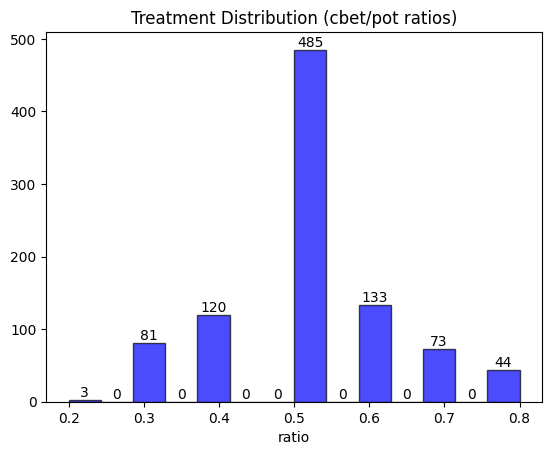

In [127]:
plot_hist(_treatments, bins=14, title="Treatment Distribution (cbet/pot ratios)", xlabel='ratio')

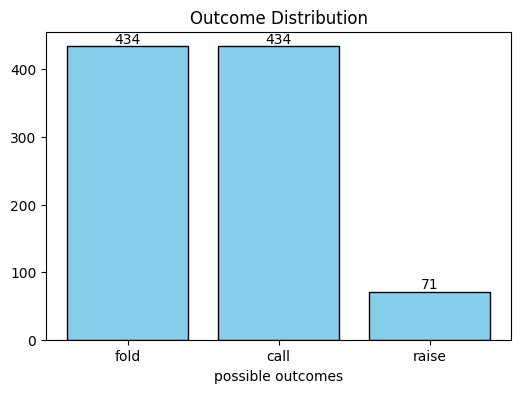

In [128]:
plot_str_hist(_outcomes, title='Outcome Distribution', xlabel='possible outcomes', width_height=(6, 4))

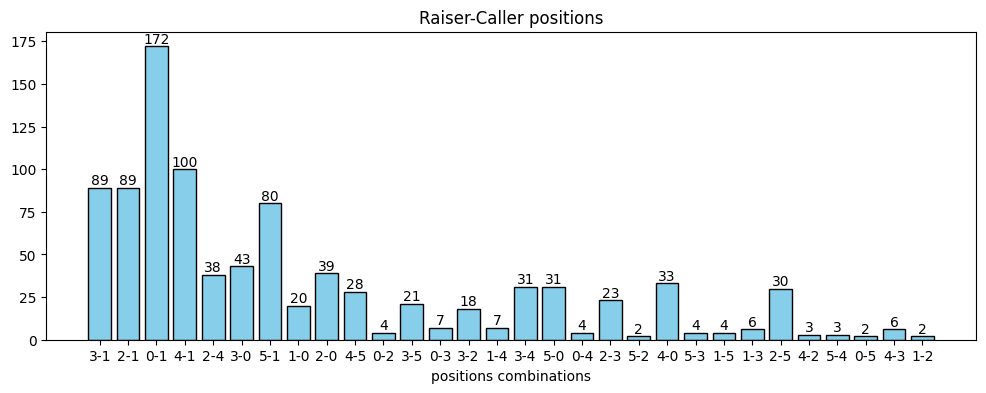

In [129]:
rc_strings = [f"{v[0]}-{v[1]}" for v in _raiser_caller_positions]
plot_str_hist(rc_strings, title='Raiser-Caller positions', xlabel='positions combinations', width_height=(12, 4))

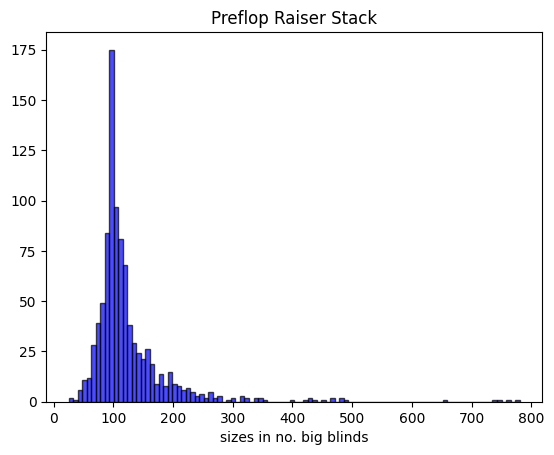

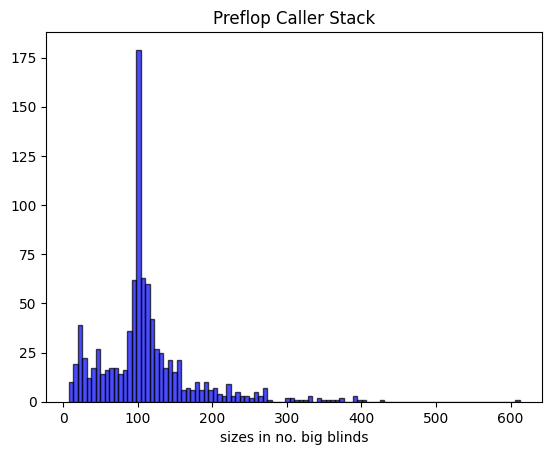

In [130]:
plot_hist([v/bb for v in raisers_stack], title="Preflop Raiser Stack", xlabel='sizes in no. big blinds', with_bar_nums=False, bins=100)
plot_hist([v/bb for v in callers_stack], title="Preflop Caller Stack", xlabel='sizes in no. big blinds', with_bar_nums=False, bins=100)

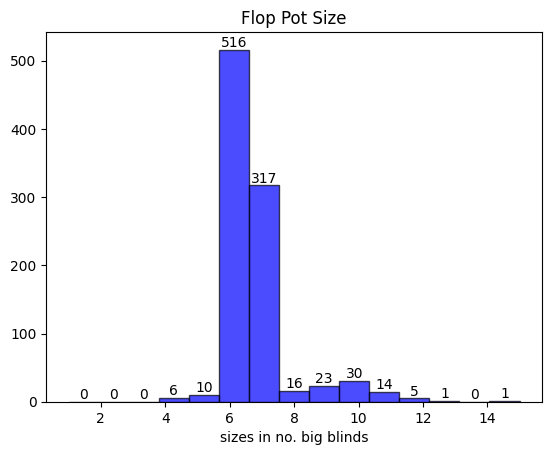

In [131]:
plot_hist([v/bb for v in pot_sizes], title="Flop Pot Size", xlabel='sizes in no. big blinds', use_range=(1, 15), bins=15)

correlations

In [132]:
treatment_outcome = {t: {'fold': 0, 'call': 0, 'raise': 0, 'tot': 0} for t in set(_treatments)}
for t, o in zip(_treatments, _outcomes):
    treatment_outcome[t][o] += 1
    treatment_outcome[t]['tot'] += 1

In [133]:
labels, fold_vals, call_vals, raise_vals = sorted(list(set(_treatments))), [], [], []
counts = []
for t in labels:
    fold_vals.append((treatment_outcome[t]['fold'] / treatment_outcome[t]['tot'])*100)
    call_vals.append((treatment_outcome[t]['call'] / treatment_outcome[t]['tot'])*100)
    raise_vals.append((treatment_outcome[t]['raise'] / treatment_outcome[t]['tot'])*100)
    counts.append(treatment_outcome[t]['tot'])

In [134]:
def plot_scatter(labels_, values_, counts_, title='', ylabel='', xlabel='c-bet size'):

    plt.figure(figsize=(8, 5))
    scatter = plt.scatter(labels_, values_, s=[c * 10 for c in counts_], alpha=0.6, c=counts_, cmap='viridis')
    plt.colorbar(scatter, label='Number of Data Points')

    # Add labels
    for label, value, count in zip(labels_, values_, counts_):
        plt.annotate(f'{count}', (label, value), textcoords="offset points", xytext=(0,5), ha='center')

    # Labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

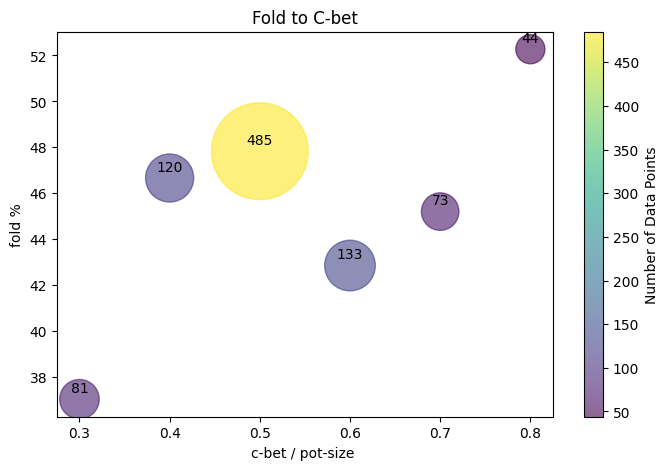

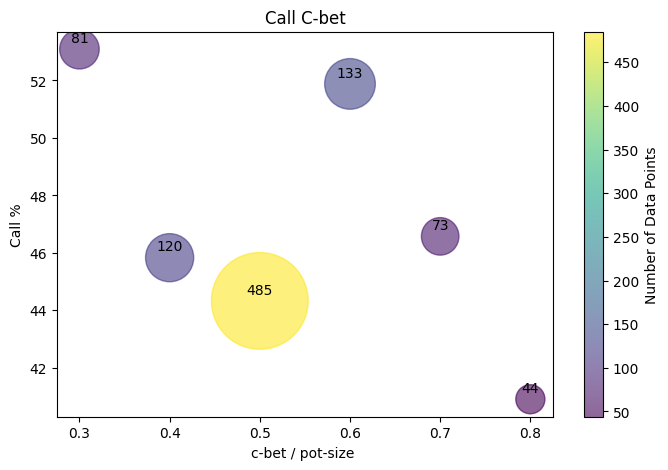

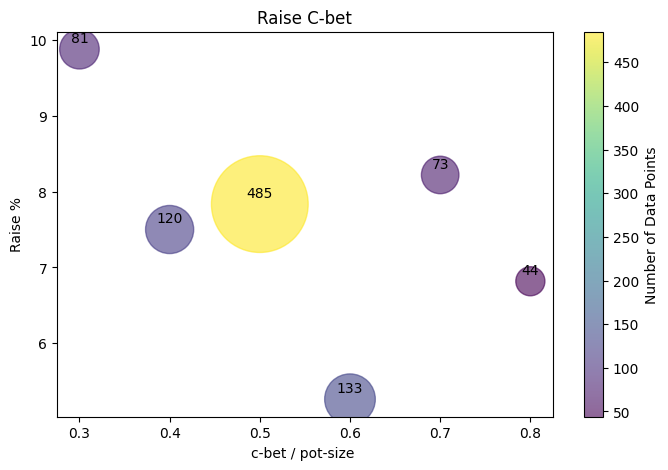

In [135]:
plot_scatter(labels[1:], fold_vals[1:], counts[1:], title='Fold to C-bet', ylabel='fold %', xlabel='c-bet / pot-size ')
plot_scatter(labels[1:], call_vals[1:], counts[1:], title='Call C-bet', ylabel='Call %', xlabel='c-bet / pot-size ')
plot_scatter(labels[1:], raise_vals[1:], counts[1:], title='Raise C-bet', ylabel='Raise %', xlabel='c-bet / pot-size ')

### Drafts